# CNN International Twitter Sentiment Analysis

Sentiment Analysis of a dataset of 200 Tweets from CNN International collected through the Twitter API on October 10th, 2021. 

The data indicates tweet id, source, source_url, user, full text of the tweet, number of favorites and number of retweets.  There are no missing values in the data. In addition to Sentiment Analysis, the relationships with the text content of the tweets, the number of favorites and number of retweets is also examined.

In [1]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
#Getting CSV file with CNN International Tweets
cnn_df = pd.read_csv('cnn_international.csv')

cnn_df.head()

,id,source,source_url,user,full_text,favorite_count,retweet_count
0,1447442092914061314,SocialFlow,http://www.socialflow.com,cnni,Anti-Semitic graffiti has been found at the Au...,54,18
1,1447441854375596035,SocialFlow,http://www.socialflow.com,cnni,Bride Sam didn't want to waste money on an exp...,37,5
2,1447434565795127301,SocialFlow,http://www.socialflow.com,cnni,"William Shatner, who debuted on ""Star Trek"" in...",79,21
3,1447427008946970624,SocialFlow,http://www.socialflow.com,cnni,Researchers have discovered the third-ever tar...,116,26
4,1447419466522968064,SocialFlow,http://www.socialflow.com,cnni,"A stray street dog in Istanbul, Turkey, has be...",247,67


# Tweets Sentiment Analysis
## Cleaning Tweet Text Content

In [34]:
#Create a function to clean the tweets (removing mentions, hashtags, links etc.)
def cleanText(text):
    ## Removing @ mentions
    #Using Regular expressions to substitute any text with the pattern below
    #Any uppercase letter A-Z, any lowercase letter a-z and any number 0-9
    #The 'r' tells python that we are looking for a raw string
    #The '+' symbols ensures we're checking for one or moreThe
    text = re.sub(r'@[A-Za-z0-9]+','',text)

    ## Removing # hashtag symbol
    text = re.sub(r'#','',text)

    ## Removing RT which indicate a ReTweetindicates some empty space
    # [\s]
    text = re.sub(r'RT[\s]','',text)

    ## Removing url
    #We add the '?' after https since some websites may have addresses starting with either http or https
    #'\S+' checks for one or more empty spaces
    text = re.sub(r'https?:\/\/\S+','',text)

    return text

In [35]:
#Creating a column with just the cleaned text data 
cnn_df['just_text'] = cnn_df['full_text'].apply(cleanText)

## Subjectivity and Polarity

- <b>Subjectivity</b> tells us how subjective the text content of a Tweet is.
- <b>Polarity</b>  lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

### Create a Function for Subjectivity and Polarity

In [5]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [6]:
#Create new columns for subjectivity and polarity
cnn_df['Subjectivity'] = cnn_df['just_text'].apply(getSubjectivity)
cnn_df['Polarity'] = cnn_df['just_text'].apply(getPolarity)

## Analysis

Tweets can be designated as Negative, Neutral or Positive based on the Polarity score.

In [7]:
#Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [8]:
#Create a new column with the analysis
cnn_df['Analysis'] = cnn_df['Polarity'].apply(getAnalysis)

### Tweets by Analysis

In [9]:
#Creating a function to print out a sorted list of tweets based on whether they are Positive, Negative or Neutral
def tweetsByAnalysis(Analysis):
    #Creating a dataframe with tweets where analysis is equal to a certain value
    tweet_df = cnn_df[cnn_df['Analysis']==Analysis]
    
    #Sorting Tweets in descending order
    tweet_df = tweet_df.sort_values(by=['Polarity'], ascending=False)
    
    return tweet_df

In [10]:
positive_tweets_df = tweetsByAnalysis('Positive')
negative_tweets_df = tweetsByAnalysis('Negative')
neutral_tweets_df = tweetsByAnalysis('Neutral')

In [11]:
#We no longer need the just_text since we have calculated the subjectivity and polarity
#We can store the just_text values in a separate dataframe

cnn_df_just_text = cnn_df.pop('just_text').to_frame()

# Exploratory Data Analysis

In this stage, we will examine the data to identify any patterns, trends and relationships between the variables. It will help us analyze the data and extract insights that can be used to make decisions.

Data Visualization will give us a clear idea of what the data means by giving it visual context.

## Text Content

We can visualize the text data we stored in cnn_df_just_text to understand what some of the Key Words in the Tweets are. The Key Words are useful in helping us understand what constitutes a Positive, Negative or Neutral Tweet, which could help in predicting user sentiments and reactions to Tweets drafts prior to posting them. 

Key Words also allow us to identify Tweets that are good examples of Positive, Negative or Neutral sentiments.

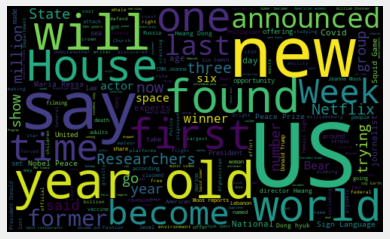

In [12]:
#Plot Word Cloud to visualize the text data

allWords = ' '.join([twts for twts in cnn_df_just_text['just_text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The World Cloud allows us to visualize how often a certain word appears in Tweets based on its relative size. As seen above the word <b>US</b> appears most often on CNN International's Tweets. However, some other words such as 'say', 'found', 'will' etc. are just verbs that do not give us as much useful information. 

We can try a different method to determine what some key words in the Tweets are that may yield more meaningful results. 

#### Alternate Way to get Key Words in Tweets

In [13]:
import nltk
from nltk.corpus import stopwords

import string

#Creating a function to process the text in the tweet and identify key words
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    #Now just remove any stopwords
    #Stopwords refer to very common words, ('the', 'a', etc..). By removing these words we can identify unique words that appear most often in tweets
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
#Creating a function to show us the top 10 Key Words from Tweets
def unique_words(df):
    #List where we will store all the unique words from tweets
    unique_words = []

    #Creating a loop to add all the unique words from each tweet
    for word in df['just_text'].apply(text_process):
        unique_words.extend(word)

    #Top 10 Key Words from tweets
    return pd.DataFrame(unique_words).value_counts().head(10)

In [15]:
unique_words(cnn_df_just_text)

US           33
says         19
—            18
one          15
new          14
Game         13
found        12
ever         12
President    12
Squid        11
dtype: int64

Once again, the word <b>US</b> appears most often on CNN International's Tweets. We also see words such as 'President', 'Squid' and 'Game' (most likely referring to the current #1 Netflix series, Squid Game) which makes more sense in the context of the news. ALthough the results are better than the Word Cloud, the other Key Words such as 'says' and 'found' do not provide any meaningful information. 

The presence of irrelevant Key Words indicates that the text_process function may have to be modified in some way to ensure irrelevant words are removed. However, this can be challengings as news tweets may be difficult to parse through accurately because of their <i>subjective</i> nature. For example, 'says' may be important in the context of who is saying something, like an announcement from a public official.

To get more context on these Key words, we can create a function that searches a list of words we pass against a dataframes with a given Sentiment Analysis value and displays all the matching Tweets.

In [16]:
#Creating a function to search a dataframe for a list of words we pass
def word_search(df,word_list): 
    #Word_list will be a list of Key Words selected from the output of unique_words(df) based on perceived relevance
    
    #Empty list to store all the matching tweets
    tweet_list = []
    for twt in df['just_text']:
        #Creating a list of strings for each tweet using .split(' ')
        for word in twt.split(' '):
            #Checking if a word from a tweet is in the word list 
            if word in word_list:
                tweet_list.append(twt)   
    
    #Multiple matching key words may appear in the same tweet so we may have duplicates in tweet_list
    #Removing duplicates
    tweet_list = list(dict.fromkeys(tweet_list))
    
    i=1
    for match_twt in tweet_list:
        print(str(i) + ') ' + match_twt +'\n')   
        i+=1

### Text Content: Positive Tweets

In [17]:
unique_words(positive_tweets_df)

US           17
new          13
—            13
says         13
ever         12
first         9
years         8
go            8
worlds        8
President     7
dtype: int64

Let's take a look at the tweets these words appear in for more context.

In [18]:
#List of words that makes sense in the context of news
positive_word_list = ['US','new','ever','first','years','worlds','President']   
word_search(positive_tweets_df,positive_word_list)

1) LEGO has revealed its largest ever set, of arguably the world's most famous boat, the RMS Titanic. 

2) "Don't ever doubt me," says Tyson Fury after winning heavyweight boxing thriller against Deontay Wilder.



3) US President Biden has announced the expansion of three national monuments — Bears Ears, Grand Staircase-Escalante, and Northeast Canyons and Seamounts Marine — in a move restoring protections that had been undone by then-President Donald Trump 

4) Vaccine advisers to the US Centers for Disease Control and Prevention have planned two meetings in the coming weeks to discuss more Covid-19 vaccine boosters, as well as Pfizer's application for emergency use authorization for its vaccine for children 5-11 

5) More than 140,000 US children have lost a parent or grandparent who takes care of them to Covid-19, CDC researchers reported Thursday, which is as many as one in 500 US kids. 

6) Czechs are set for new leader, as opposition groups are on track to win parliamentary majo

### Text Content: Negative Tweets

In [19]:
unique_words(negative_tweets_df)

Game       9
climate    7
Squid      7
news       6
US         5
found      5
number     5
Netflix    5
money      5
said       5
dtype: int64

It's interesting that some of the main Key Words from Positive Tweets are also main Key Words in Negative Tweets('Squid','Game','US' and 'found'). Perhaps this reflects some Tweets indicative of both sides of some news article. Let's take a look at the tweets these words appear in for more context.

In [20]:
#List of words that makes sense in the context of news
negative_word_list = ['Game ','climate','Squid','news','US','number','Netflix','money']   
word_search(negative_tweets_df,positive_word_list)

1) Children are almost as likely as adults to become infected with coronavirus, but they are less likely to have symptoms, according to a new study 

2) Half a billion dollars of aircraft that flew for about a year. A huge $85 million hotel that never opened, and sits in disrepair. Hundreds of billions were spent by the US in Afghanistan. 

Here are 10 of the starkest examples of 'waste, fraud and abuse.' 

3) A federal judge has sentenced one of the US Capitol rioters to three months in jail, saying that the punishment should be a warning to other defendants that they deserve incarceration if they deflect responsibility or downplay the attack. 

4) Afghan evacuee flights to the US from Ramstein Air Base resume after pausing for weeks due to confirmed cases of measles amongst evacuees. 

5) The US Department of Justice has announced it will not pursue federal criminal civil rights charges against the Wisconsin police officer who shot Jacob Blake seven times, paralyzing him from the wai

### Text Content: Neutral Tweets

In [21]:
unique_words(neutral_tweets_df)

US             11
Week            7
bear            6
former          6
Philippines     6
time            5
Bear            5
—               5
CNN             5
months          5
dtype: int64

Let's take a look at the tweets these words appear in for more context.

In [22]:
#List of words that makes sense in the context of news
neutral_word_list = ['US ','Week','bear','former','US','Philippines','time','money']   
word_search(neutral_tweets_df,positive_word_list)

1) JUST IN: A US federal appeals court has put a temporary hold on a judge's order blocking Texas' six-week abortion ban. 

2) The Biden administration is canceling another slate of border wall contracts — this time, in the Laredo and Rio Grande Valley sectors, the US Department of Homeland Security has announced 

3) A US federal jury has found two wealthy parents charged in a national conspiracy that facilitated cheating on college admissions for their children guilty on all counts, the US Attorney's Office announced. 

4) Steve Bannon will not cooperate with the US House select committee investigating January 6, his lawyer said in an email obtained by CNN that cites former President Donald Trump's claim of executive privilege. 

5) The White House has informed the US National Archives it will not assert executive privilege on behalf of former President Trump, paving the way for the Archives to share documents with the House committee investigating the Capitol riot, a source says 

6

As seen in the sections above for Positive, Negative, and Neutral Tweets, there are <b>clearly some tweets that are placed in the wrong categories.</b> The potential causes for this could be as follows:

- The range for Positive, Negative, and Neutral Sentiments needs to be adjusted to more accurately reflect these sentiments.
- The Polarity may not provide an accurate assessment of the Tweet Sentiment; a different metric may be necessary. 
- A different function might be necessary to clean the data prior to calculating Polarity and Subjectivity.

## Polarity vs. Subjectivity

Text(0.5, 1.0, 'Twitter Sentiment Analysis')

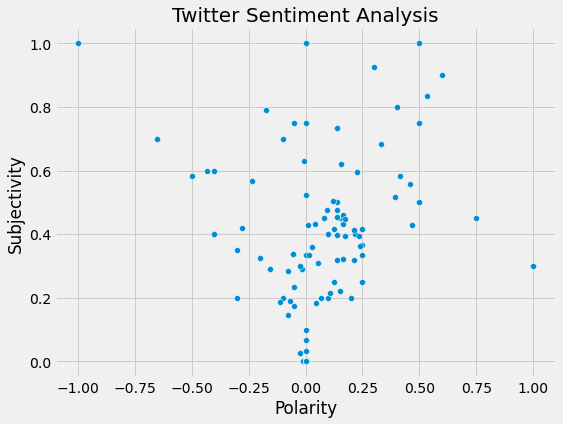

In [23]:
#PLot the Polarity and Subjectivity
plt.figure(figsize=(8,6))

sns.scatterplot(y='Subjectivity',x='Polarity', data=cnn_df)
plt.title('Twitter Sentiment Analysis',fontsize=20)


### Polarity vs. Subjectivity: Popular Tweets

We will define popular tweets as tweets that get over 50 favorites and retweets. Highlighting these points will help us understand how polarity and subjectivity affect the popularity of a Tweet. 

Text(0.5, 1.0, 'Twitter Sentiment Analysis')

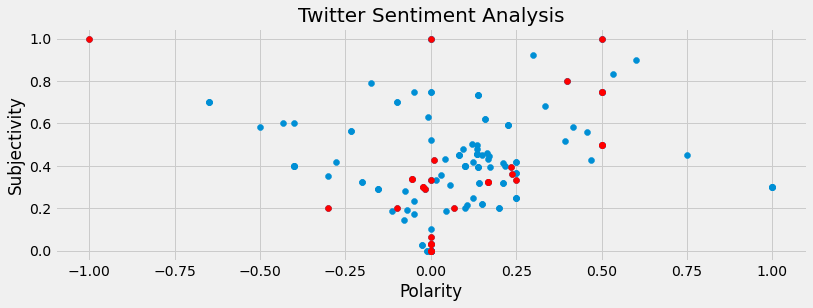

In [24]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)

#Tweets with over 50 Favorites and over 50 Retweets
pop_tweets = cnn_df[(cnn_df['favorite_count']>50) & (cnn_df['retweet_count']>50)]

ax.scatter(y='Subjectivity',x='Polarity', data=cnn_df)
ax.scatter(y='Subjectivity',x='Polarity', data=pop_tweets,facecolor="red")
ax.set_xlabel("Polarity")
ax.set_ylabel("Subjectivity")
ax.set_title('Twitter Sentiment Analysis',fontsize=20)

In [25]:
#Number of Popular Tweets
len(pop_tweets)

33

In [26]:
#Number of Tweets with subjectivity of less than 0.5< and polarity of between -0.25 to +0.25. 
len(cnn_df[(cnn_df['Subjectivity']<0.5) & (cnn_df['Polarity']>-0.25)& (cnn_df['Polarity']<0.25)])

125

The majority of CNN International's popular tweets tend to have a <b>subjectivity of less than 0.5</b> and a <b>polarity of between -0.25 to +0.25</b>. 

However, the same is true for the majority of their tweets, which indicates that subjectivity and polarity values by themselves do not have a significant correlation with the popularity of a tweet.  

## Analysis

Text(0.5, 1.0, 'Percentage of Tweets by Sentiment Analysis Category')

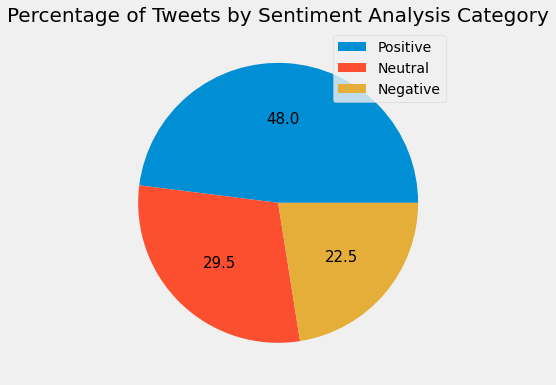

In [27]:
analysis_df = cnn_df['Analysis'].value_counts()

analysis_df.plot.pie(figsize=(6, 6), autopct="%.1f",fontsize=15,labels=None, legend=True).set_ylabel('')
plt.title("Percentage of Tweets by Sentiment Analysis Category", fontsize=20)

# autopct="%.1f" shows the percentage to 1 decimal place 
#.set_ylabel('') and can be added to remove the usertype label on the left of the chart.set_ylabel('')

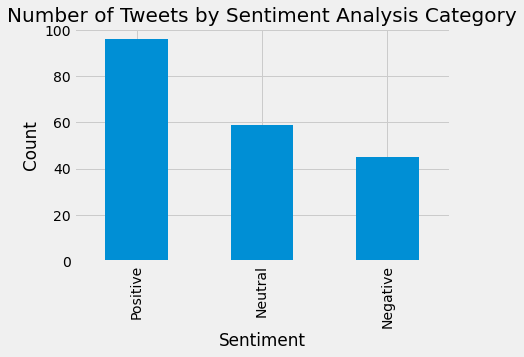

In [28]:
#Plot and visualize value counts
plt.title("Number of Tweets by Sentiment Analysis Category", fontsize=20)
plt.xlabel('Sentiment')
plt.ylabel('Count')
cnn_df['Analysis'].value_counts().plot(kind='bar')
plt.show()

<b>Positive</b> Tweets outnumber Neutral and Negative Tweets. 

### Analysis vs. Number of Favorites

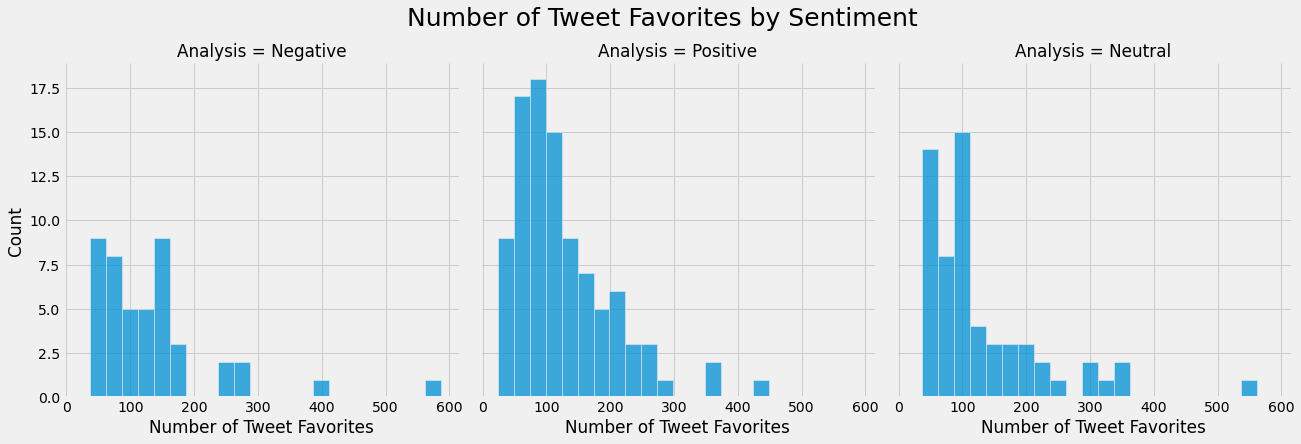

In [36]:
graph = sns.FacetGrid(cnn_df, col="Analysis", height=6)
graph.map_dataframe(sns.histplot,x="favorite_count",binwidth=25)

#Setting the title for the FacetGrid 
graph.fig.subplots_adjust(top=0.85)
graph.fig.suptitle('Number of Tweet Favorites by Sentiment', fontsize=25)
graph.set_axis_labels("Number of Tweet Favorites", "Count")

- Most Negative Tweets receive approx. <b>between 30-55 favorites</b> or <b>between 140-165 favorites.</b>
- Most Positive Tweets receive approx. <b>between 50-125 favorites.</b>
- Most Neutral Tweets receive approx. <b>between 35-60 favorites.</b> or <b>between 85-110 favorites.</b>

Note: Each bar is a range of 25 favorites.

In [37]:
#Calculating the Average Number of favorites by Analysis value
mean_list = [positive_tweets_df['favorite_count'].mean(),negative_tweets_df['favorite_count'].mean(),neutral_tweets_df['favorite_count'].mean()]
[round(num) for num in mean_list]

[126, 134, 130]

<b>Negative Tweets</b> receive the most favorites on average, followed by Neutral Tweets and then Positive Tweets

### Analysis vs. Number of Retweets

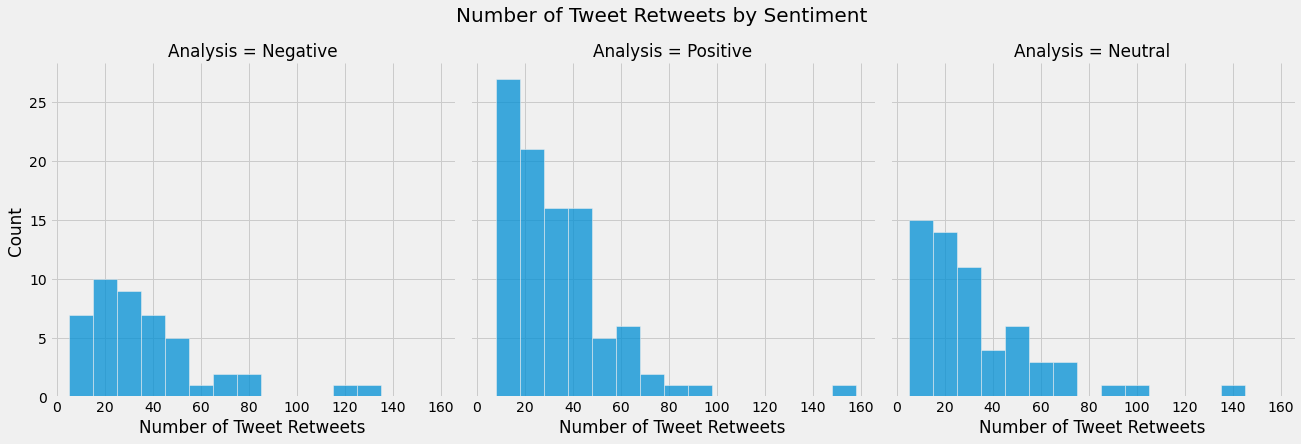

In [38]:
graph = sns.FacetGrid(cnn_df, col="Analysis", height=6)
graph.map_dataframe(sns.histplot,x="retweet_count",binwidth=10)

#Setting the title for the FacetGrid 
graph.fig.subplots_adjust(top=0.85)
graph.fig.suptitle('Number of Tweet Retweets by Sentiment', fontsize=20)
graph.set_axis_labels("Number of Tweet Retweets", "Count")

- Most Negative Tweets receive approx. <b>between 5-55 retweets.</b>
- Most Positive Tweets receive approx. <b>between 10-50 retweets.</b>
- Most Neutral Tweets receive approx. <b>between 5-35 retweets.</b>

Note: Each bar is a range of 10 retweets.

In [32]:
#Calculating the Average Number of favorites by Analysis value
mean_list = [positive_tweets_df['retweet_count'].mean(),negative_tweets_df['retweet_count'].mean(),neutral_tweets_df['retweet_count'].mean()]
[round(num) for num in mean_list]

[33, 36, 32]

<b>Negative Tweets</b> receive the most retweets on average, followed by Positive Tweets and then Neutral Tweets

# Summary of Sentiment Analysis

The Key Word <b>'US'</b> appears most often on CNN International's Tweets, and it is a top Key Word in all types of Tweets: Positive, Negative and Neutral. There was also some degree of overlap between the top Key Words in both Positive and Negative Tweets, suggesting that some Tweets may reflect both sides of a news article. 

<b>Positive Tweets</b> represent the biggest portion of Tweets, followed by Neutral and then Negative Tweets.

However, <b>Negative Tweets</b> receive the most favorites and retweets on average, which suggests that Negative Tweets are the most popular despite appearing the least often. 

The majority of CNN International's popular tweets, and their tweets in general, tend to have a <b>Subjectivity of less than 0.5</b> and a <b>Polarity of between -0.25 to +0.25</b>. The observation suggests that most Tweets are close to Neutral. As CNN International is a news source this sentiment would make sense as it would be the result of an intentional attempt to post relatively neutral, informative content, allowing the readers to make their own judgement. 

## Limitations

The Analysis revealed that there are <b>clearly some tweets that are placed in the wrong sentiment categories.</b> The potential causes for this could be as follows:

- The range for Positive, Negative, and Neutral Sentiments needs to be adjusted to more accurately reflect these sentiments.
- The Polarity may not provide an accurate assessment of the Tweet Sentiment; a different metric may be necessary. 
- A different function might be necessary to clean the data prior to calculating Polarity and Subjectivity.
